# Introduction

To study inequality of educational opportunity in U.S. high schools. Here the focus is on average student performance on the ACT or SAT exams that students take as part of the college application process.



# Import libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')
import missingno as msno

# Train-test splits
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV

# Model preprocessing
from sklearn.preprocessing import StandardScaler
from patsy import dmatrices

# Modeling
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from itertools import combinations
from scipy.stats import uniform, randint

# Model metrics and analysis
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn import metrics

# Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# The data

This project utilizes two data sets. The primary data set is the EdGap data set from [EdGap.org](https://www.edgap.org/#5/37.875/-96.987). This data set from 2016 includes information about average ACT or SAT scores for schools and several socioeconomic characteristics of the school district. The secondary data set is basic information about each school from the [National Center for Education Statistics](https://nces.ed.gov/ccd/pubschuniv.asp).





### EdGap data

All socioeconomic data (household income, unemployment, adult educational attainment, and family structure) are from the Census Bureau's American Community Survey.

[EdGap.org](https://www.edgap.org/#5/37.875/-96.987) report that ACT and SAT score data is from each state's department of education or some other public data release.


[EdGap.org](https://www.edgap.org/#5/37.875/-96.987) do not indicate that they processed the data in any way. The data were assembled by the [EdGap.org](https://www.edgap.org/#5/37.875/-96.987) team.

### School information data

The school information data is from the [National Center for Education Statistics](https://nces.ed.gov/ccd/pubschuniv.asp). This data set consists of basic identifying information about schools.

# Load the data

Below code loads the EdGap
 data set

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
edgap = pd.read_excel('/content/drive/MyDrive/Projects/EdGap_data.xlsx')

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Below code loads the school information data

In [9]:
!wget https://www.dropbox.com/s/lkl5nvcdmwyoban/ccd_sch_029_1617_w_1a_11212017.csv?dl=0

--2024-09-25 22:40:27--  https://www.dropbox.com/s/lkl5nvcdmwyoban/ccd_sch_029_1617_w_1a_11212017.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/o8wf1f534pb4u7uavgjxm/ccd_sch_029_1617_w_1a_11212017.csv?rlkey=k2aey38xie2vz9ge4a0v3rrib&dl=0 [following]
--2024-09-25 22:40:28--  https://www.dropbox.com/scl/fi/o8wf1f534pb4u7uavgjxm/ccd_sch_029_1617_w_1a_11212017.csv?rlkey=k2aey38xie2vz9ge4a0v3rrib&dl=0
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1a2c561a5dfbe2ef23e2101934.dl.dropboxusercontent.com/cd/0/inline/CbR7K9d_D9oGE97NZvvRDxYeyxXBEC9oV1lv17P2ZZHd5ilsHPViObnctCRotccmql52KvwkYxgU9ToiT9oUJbxXaLJ4vhaDh6bxiJYZ_bygr7wlxkkZduD6CpIjNe0ewNE/file# [following]
--2024-09-25 22:40:29--  https://uc1a2

In [10]:
school_info = pd.read_csv('ccd_sch_029_1617_w_1a_11212017.csv?dl=0', encoding='unicode_escape')

<ipython-input-10-da1a7837c049>:1: DtypeWarning: Columns (6,9,14,15,18,19,21,22,25,26,29,31,35,39,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  school_info = pd.read_csv('ccd_sch_029_1617_w_1a_11212017.csv?dl=0', encoding='unicode_escape')


## Exploring the contents of the data sets

In [11]:
school_info.describe()

,FIPST,UNION,NCESSCH,SCHID
count,102183.000000,2533.000000,1.021810e+05,1.021810e+05
mean,29.018496,207.158310,2.913297e+11,2.904893e+06
std,16.844778,125.767108,1.684048e+11,1.684249e+06
min,1.000000,1.000000,1.000020e+10,1.000010e+05
25%,13.000000,50.000000,1.302550e+11,1.302169e+06
50%,29.000000,300.000000,2.911250e+11,2.900753e+06
75%,42.000000,300.000000,4.220250e+11,4.206624e+06
max,78.000000,301.000000,7.800030e+11,7.800037e+06


Numerical summaries displayed above

In [12]:
school_info

,SCHOOL_YEAR,FIPST,STATENAME,ST,SCH_NAME,LEA_NAME,STATE_AGENCY_NO,UNION,ST_LEAID,LEAID,...,G_10_OFFERED,G_11_OFFERED,G_12_OFFERED,G_13_OFFERED,G_UG_OFFERED,G_AE_OFFERED,GSLO,GSHI,LEVEL,IGOFFERED
0,2016-2017,1,ALABAMA,AL,Sequoyah Sch - Chalkville Campus,Alabama Youth Services,1,NaN,AL-210,100002,...,Yes,Yes,Yes,No,No,No,07,12,High,As reported
1,2016-2017,1,ALABAMA,AL,Camps,Alabama Youth Services,1,NaN,AL-210,100002,...,Yes,Yes,Yes,No,No,No,07,12,High,As reported
2,2016-2017,1,ALABAMA,AL,Det Ctr,Alabama Youth Services,1,NaN,AL-210,100002,...,Yes,Yes,Yes,No,No,No,07,12,High,As reported
3,2016-2017,1,ALABAMA,AL,Wallace Sch - Mt Meigs Campus,Alabama Youth Services,1,NaN,AL-210,100002,...,Yes,Yes,Yes,No,No,No,07,12,High,As reported
4,2016-2017,1,ALABAMA,AL,McNeel Sch - Vacca Campus,Alabama Youth Services,1,NaN,AL-210,100002,...,Yes,Yes,Yes,No,No,No,07,12,High,As reported
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102178,2016-2017,78,U.S. VIRGIN ISLANDS,VI,GLADYS A. ABRAHAM ELEMENTARY SCHOOL,Saint Thomas - Saint John School District,1,NaN,VI-001,7800030,...,No,No,No,No,No,No,KG,06,Elementary,As reported
102179,2016-2017,78,U.S. VIRGIN ISLANDS,VI,ULLA F MULLER ELEMENTARY SCHOOL,Saint Thomas - Saint John School District,1,NaN,VI-001,7800030,...,No,No,No,No,No,No,KG,06,Elementary,As reported
102180,2016-2017,78,U.S. VIRGIN ISLANDS,VI,YVONNE BOWSKY ELEMENTARY SCHOOL,Saint Thomas - Saint John School District,1,NaN,VI-001,7800030,...,No,No,No,No,No,No,KG,06,Elementary,As reported
102181,2016-2017,78,U.S. VIRGIN ISLANDS,VI,CANCRYN JUNIOR HIGH SCHOOL,Saint Thomas - Saint John School District,1,NaN,VI-001,7800030,...,No,No,No,No,No,No,07,08,Middle,As reported


In [13]:
edgap.describe()

,NCESSCH School ID,CT Unemployment Rate,CT Pct Adults with College Degree,CT Pct Childre In Married Couple Family,CT Median Household Income,School ACT average (or equivalent if SAT score),School Pct Free and Reduced Lunch
count,7.986000e+03,7972.000000,7973.000000,7961.000000,7966.000000,7986.000000,7986.000000
mean,3.321869e+11,0.098730,0.568930,0.633440,52026.905222,20.181532,0.420651
std,1.323638e+11,0.058959,0.165704,0.196764,24228.057079,2.595201,0.239754
min,1.000016e+11,0.000000,0.091493,0.000000,3589.000000,-3.070818,-0.054545
25%,2.105340e+11,0.058655,0.450828,0.523810,36597.250000,18.600000,0.238501
50%,3.600085e+11,0.085649,0.554979,0.667594,46833.500000,20.400000,0.381570
75%,4.226678e+11,0.123376,0.676571,0.777135,61369.250000,21.910867,0.575447
max,5.605830e+11,0.590278,1.000000,1.000000,226181.000000,32.362637,0.998729


Numerical summaries displayed above

In [14]:
edgap

,NCESSCH School ID,CT Unemployment Rate,CT Pct Adults with College Degree,CT Pct Childre In Married Couple Family,CT Median Household Income,School ACT average (or equivalent if SAT score),School Pct Free and Reduced Lunch
0,100001600143,0.117962,0.445283,0.346495,42820.0,20.433455,0.066901
1,100008000024,0.063984,0.662765,0.767619,89320.0,19.498168,0.112412
2,100008000225,0.056460,0.701864,0.713090,84140.0,19.554335,0.096816
3,100017000029,0.044739,0.692062,0.641283,56500.0,17.737485,0.296960
4,100018000040,0.077014,0.640060,0.834402,54015.0,18.245421,0.262641
...,...,...,...,...,...,...,...
7981,560530200294,0.034549,0.590780,0.720077,64891.0,18.500000,0.232156
7982,560569000311,0.069538,0.633860,0.808841,44603.0,22.300000,0.083871
7983,560569500360,0.035159,0.764566,0.776570,44896.0,21.500000,0.184829
7984,560576200324,0.063877,0.670532,0.879324,92134.0,19.700000,0.112583


## Quick exploratory data analysis

In [15]:
edgap.columns

Index(['NCESSCH School ID', 'CT Unemployment Rate',
       'CT Pct Adults with College Degree',
       'CT Pct Childre In Married Couple Family', 'CT Median Household Income',
       'School ACT average (or equivalent if SAT score)',
       'School Pct Free and Reduced Lunch'],
      dtype='object')

In [16]:
school_info.columns

Index(['SCHOOL_YEAR', 'FIPST', 'STATENAME', 'ST', 'SCH_NAME', 'LEA_NAME',
       'STATE_AGENCY_NO', 'UNION', 'ST_LEAID', 'LEAID', 'ST_SCHID', 'NCESSCH',
       'SCHID', 'MSTREET1', 'MSTREET2', 'MSTREET3', 'MCITY', 'MSTATE', 'MZIP',
       'MZIP4', 'LSTREET1', 'LSTREET2', 'LSTREET3', 'LCITY', 'LSTATE', 'LZIP',
       'LZIP4', 'PHONE', 'WEBSITE', 'SY_STATUS', 'SY_STATUS_TEXT',
       'UPDATED_STATUS', 'UPDATED_STATUS_TEXT', 'EFFECTIVE_DATE',
       'SCH_TYPE_TEXT', 'SCH_TYPE', 'RECON_STATUS', 'OUT_OF_STATE_FLAG',
       'CHARTER_TEXT', 'CHARTAUTH1', 'CHARTAUTHN1', 'CHARTAUTH2',
       'CHARTAUTHN2', 'NOGRADES', 'G_PK_OFFERED', 'G_KG_OFFERED',
       'G_1_OFFERED', 'G_2_OFFERED', 'G_3_OFFERED', 'G_4_OFFERED',
       'G_5_OFFERED', 'G_6_OFFERED', 'G_7_OFFERED', 'G_8_OFFERED',
       'G_9_OFFERED', 'G_10_OFFERED', 'G_11_OFFERED', 'G_12_OFFERED',
       'G_13_OFFERED', 'G_UG_OFFERED', 'G_AE_OFFERED', 'GSLO', 'GSHI', 'LEVEL',
       'IGOFFERED'],
      dtype='object')

Below code displays correlation matrix

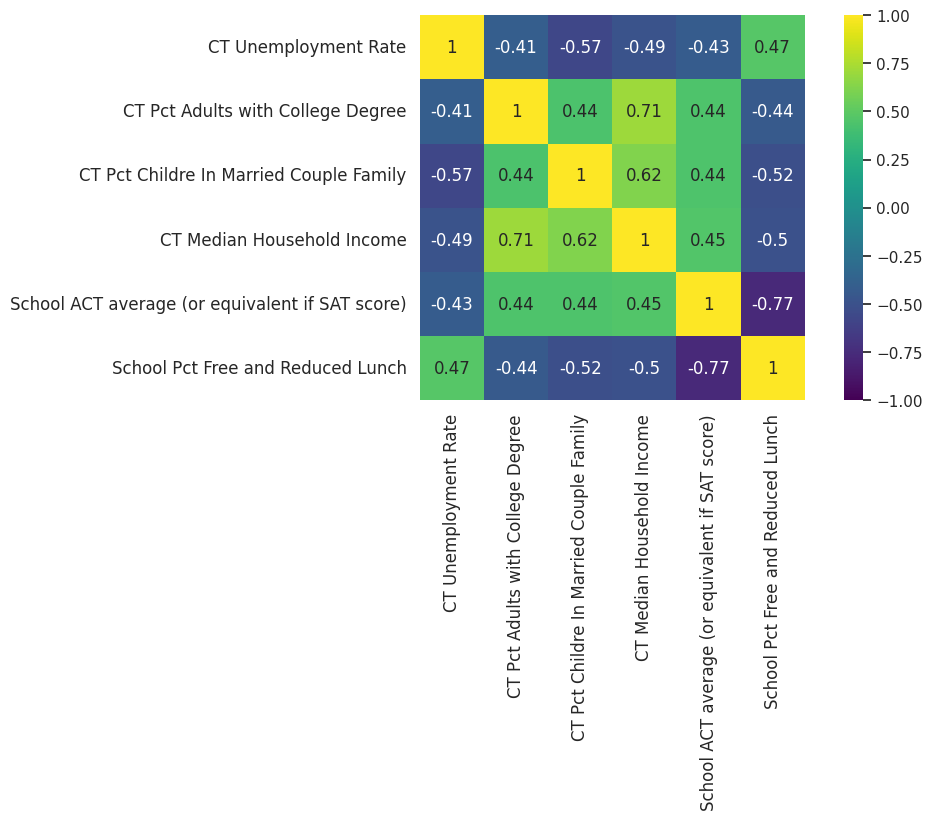

In [17]:
corr_matrix = edgap[['CT Unemployment Rate',
       'CT Pct Adults with College Degree',
       'CT Pct Childre In Married Couple Family', 'CT Median Household Income',
       'School ACT average (or equivalent if SAT score)',
       'School Pct Free and Reduced Lunch']].corr()

plt.figure(figsize=(10,5))

sns.heatmap(corr_matrix, vmax=1, vmin=-1, square=True, annot=True, cmap='viridis')

plt.tick_params(labelsize=12);

# Data Preparation

## Selecting relevant subsets of the data

In [18]:
school_info=school_info[["SCHOOL_YEAR", "NCESSCH", "MSTATE", "MZIP", "SCH_TYPE_TEXT", "LEVEL"]]
school_info

,SCHOOL_YEAR,NCESSCH,MSTATE,MZIP,SCH_TYPE_TEXT,LEVEL
0,2016-2017,1.000020e+10,AL,35220,Alternative School,High
1,2016-2017,1.000020e+10,AL,36057,Alternative School,High
2,2016-2017,1.000020e+10,AL,36057,Alternative School,High
3,2016-2017,1.000020e+10,AL,36057,Alternative School,High
4,2016-2017,1.000020e+10,AL,35206,Alternative School,High
...,...,...,...,...,...,...
102178,2016-2017,7.800030e+11,VI,802,Regular School,Elementary
102179,2016-2017,7.800030e+11,VI,802,Regular School,Elementary
102180,2016-2017,7.800030e+11,VI,802,Regular School,Elementary
102181,2016-2017,7.800030e+11,VI,802,Regular School,Middle


## Rename columns

In [19]:
edgap = edgap.rename(columns={"NCESSCH School ID":"id",
              "CT Pct Adults with College Degree":"percent_college",
              "CT Unemployment Rate":"rate_unemployment",
              "CT Pct Childre In Married Couple Family":"percent_married",
              "CT Median Household Income":"median_income",
              "School ACT average (or equivalent if SAT score)":"average_act",
              "School Pct Free and Reduced Lunch":"percent_lunch"})

In [20]:
edgap

,id,rate_unemployment,percent_college,percent_married,median_income,average_act,percent_lunch
0,100001600143,0.117962,0.445283,0.346495,42820.0,20.433455,0.066901
1,100008000024,0.063984,0.662765,0.767619,89320.0,19.498168,0.112412
2,100008000225,0.056460,0.701864,0.713090,84140.0,19.554335,0.096816
3,100017000029,0.044739,0.692062,0.641283,56500.0,17.737485,0.296960
4,100018000040,0.077014,0.640060,0.834402,54015.0,18.245421,0.262641
...,...,...,...,...,...,...,...
7981,560530200294,0.034549,0.590780,0.720077,64891.0,18.500000,0.232156
7982,560569000311,0.069538,0.633860,0.808841,44603.0,22.300000,0.083871
7983,560569500360,0.035159,0.764566,0.776570,44896.0,21.500000,0.184829
7984,560576200324,0.063877,0.670532,0.879324,92134.0,19.700000,0.112583


In [21]:
school_info = school_info.rename(columns={"SCHOOL_YEAR":"year","NCESSCH":"id","MSTATE":"state","MZIP":"zip_code","SCH_TYPE_TEXT":"school_type","LEVEL":"school_level"
              })
school_info

,year,id,state,zip_code,school_type,school_level
0,2016-2017,1.000020e+10,AL,35220,Alternative School,High
1,2016-2017,1.000020e+10,AL,36057,Alternative School,High
2,2016-2017,1.000020e+10,AL,36057,Alternative School,High
3,2016-2017,1.000020e+10,AL,36057,Alternative School,High
4,2016-2017,1.000020e+10,AL,35206,Alternative School,High
...,...,...,...,...,...,...
102178,2016-2017,7.800030e+11,VI,802,Regular School,Elementary
102179,2016-2017,7.800030e+11,VI,802,Regular School,Elementary
102180,2016-2017,7.800030e+11,VI,802,Regular School,Elementary
102181,2016-2017,7.800030e+11,VI,802,Regular School,Middle


## Joining of the data frames

In [22]:
school_info = school_info[school_info['id'].isna() == False]

The variable is recasted as an `int64`.

In [23]:
school_info['id'] = school_info['id'].astype('int64')

<ipython-input-23-f85f8537330a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  school_info['id'] = school_info['id'].astype('int64')


In [24]:
edgap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7986 entries, 0 to 7985
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 7986 non-null   int64  
 1   rate_unemployment  7972 non-null   float64
 2   percent_college    7973 non-null   float64
 3   percent_married    7961 non-null   float64
 4   median_income      7966 non-null   float64
 5   average_act        7986 non-null   float64
 6   percent_lunch      7986 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 436.9 KB


In [25]:
school_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102181 entries, 0 to 102182
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   year          102181 non-null  object
 1   id            102181 non-null  int64 
 2   state         102181 non-null  object
 3   zip_code      102181 non-null  object
 4   school_type   102179 non-null  object
 5   school_level  102179 non-null  object
dtypes: int64(1), object(5)
memory usage: 5.5+ MB


In [26]:
df=edgap.merge(school_info,how='left',on='id')
df

,id,rate_unemployment,percent_college,percent_married,median_income,average_act,percent_lunch,year,state,zip_code,school_type,school_level
0,100001600143,0.117962,0.445283,0.346495,42820.0,20.433455,0.066901,2016-2017,DE,19804,Regular School,High
1,100008000024,0.063984,0.662765,0.767619,89320.0,19.498168,0.112412,2016-2017,DE,19709,Regular School,High
2,100008000225,0.056460,0.701864,0.713090,84140.0,19.554335,0.096816,2016-2017,DE,19709,Regular School,High
3,100017000029,0.044739,0.692062,0.641283,56500.0,17.737485,0.296960,2016-2017,DE,19958,Regular School,High
4,100018000040,0.077014,0.640060,0.834402,54015.0,18.245421,0.262641,2016-2017,DE,19934,Regular School,High
...,...,...,...,...,...,...,...,...,...,...,...,...
7981,560530200294,0.034549,0.590780,0.720077,64891.0,18.500000,0.232156,2016-2017,WY,82902,Regular School,High
7982,560569000311,0.069538,0.633860,0.808841,44603.0,22.300000,0.083871,2016-2017,WY,82833,Regular School,High
7983,560569500360,0.035159,0.764566,0.776570,44896.0,21.500000,0.184829,2016-2017,WY,82801,Regular School,High
7984,560576200324,0.063877,0.670532,0.879324,92134.0,19.700000,0.112583,2016-2017,WY,82935,Regular School,High


## Quality Control

##### $\rightarrow$ Below code blocks check for out-of-range values and duplicate rows


In [27]:
duplicates = df.duplicated()
duplicates.sum()


0

<Axes: >

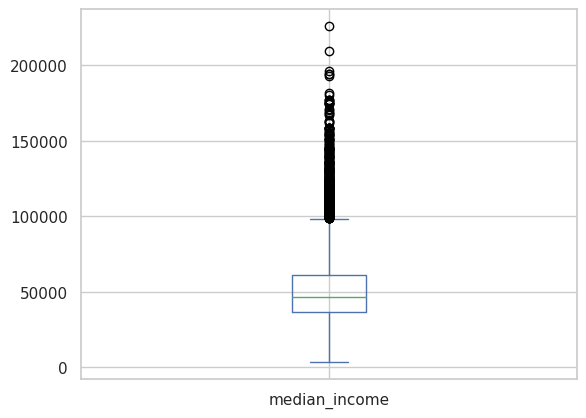

In [28]:
import matplotlib.pyplot as plt

df['median_income'].plot(kind='box')

In [29]:
df.describe()

,id,rate_unemployment,percent_college,percent_married,median_income,average_act,percent_lunch
count,7.986000e+03,7972.000000,7973.000000,7961.000000,7966.000000,7986.000000,7986.000000
mean,3.321869e+11,0.098730,0.568930,0.633440,52026.905222,20.181532,0.420651
std,1.323638e+11,0.058959,0.165704,0.196764,24228.057079,2.595201,0.239754
min,1.000016e+11,0.000000,0.091493,0.000000,3589.000000,-3.070818,-0.054545
25%,2.105340e+11,0.058655,0.450828,0.523810,36597.250000,18.600000,0.238501
50%,3.600085e+11,0.085649,0.554979,0.667594,46833.500000,20.400000,0.381570
75%,4.226678e+11,0.123376,0.676571,0.777135,61369.250000,21.910867,0.575447
max,5.605830e+11,0.590278,1.000000,1.000000,226181.000000,32.362637,0.998729


In [30]:
df.loc[df['percent_lunch']<0,'percent_lunch']=np.nan
df.loc[df['average_act']<1,'average_act']=np.nan

In [31]:
df['school_type'].value_counts()

,count
school_type,
Regular School,7885
Alternative School,10
Special Education School,2
Career and Technical School,1


In [32]:
df['school_level'].value_counts()

,count
school_level,
High,7230
Other,631
Not reported,35
Elementary,2


In [33]:
df['school_level'].isin(['Other','Not reported','Elementary'])

,school_level
0,False
1,False
2,False
3,False
4,False
...,...
7981,False
7982,False
7983,False
7984,False


In [34]:
df=df[df['school_level']=='High']

In above code, selected only rows where SCHOOL LEVEL ==HIGH

## Identify missing values

In [35]:
df.isna().mean().round(4)*100

,0
id,0.00
rate_unemployment,0.17
percent_college,0.15
percent_married,0.28
median_income,0.22
average_act,0.04
percent_lunch,0.28
year,0.00
state,0.00
zip_code,0.00


##### $\rightarrow$ Below code is to determine whether there are missing values in the data set.


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7230 entries, 0 to 7985
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 7230 non-null   int64  
 1   rate_unemployment  7218 non-null   float64
 2   percent_college    7219 non-null   float64
 3   percent_married    7210 non-null   float64
 4   median_income      7214 non-null   float64
 5   average_act        7227 non-null   float64
 6   percent_lunch      7210 non-null   float64
 7   year               7230 non-null   object 
 8   state              7230 non-null   object 
 9   zip_code           7230 non-null   object 
 10  school_type        7230 non-null   object 
 11  school_level       7230 non-null   object 
dtypes: float64(6), int64(1), object(5)
memory usage: 734.3+ KB


There are missing values in dataset. In below code, missing rows corresponding to missing values of average_act variable are dropped

In [37]:
df=df.dropna(subset=['average_act'])

In [38]:
df.isna().sum()

,0
id,0
rate_unemployment,12
percent_college,11
percent_married,20
median_income,16
average_act,0
percent_lunch,20
year,0
state,0
zip_code,0


## Train test split

In [39]:
df

,id,rate_unemployment,percent_college,percent_married,median_income,average_act,percent_lunch,year,state,zip_code,school_type,school_level
0,100001600143,0.117962,0.445283,0.346495,42820.0,20.433455,0.066901,2016-2017,DE,19804,Regular School,High
1,100008000024,0.063984,0.662765,0.767619,89320.0,19.498168,0.112412,2016-2017,DE,19709,Regular School,High
2,100008000225,0.056460,0.701864,0.713090,84140.0,19.554335,0.096816,2016-2017,DE,19709,Regular School,High
3,100017000029,0.044739,0.692062,0.641283,56500.0,17.737485,0.296960,2016-2017,DE,19958,Regular School,High
4,100018000040,0.077014,0.640060,0.834402,54015.0,18.245421,0.262641,2016-2017,DE,19934,Regular School,High
...,...,...,...,...,...,...,...,...,...,...,...,...
7981,560530200294,0.034549,0.590780,0.720077,64891.0,18.500000,0.232156,2016-2017,WY,82902,Regular School,High
7982,560569000311,0.069538,0.633860,0.808841,44603.0,22.300000,0.083871,2016-2017,WY,82833,Regular School,High
7983,560569500360,0.035159,0.764566,0.776570,44896.0,21.500000,0.184829,2016-2017,WY,82801,Regular School,High
7984,560576200324,0.063877,0.670532,0.879324,92134.0,19.700000,0.112583,2016-2017,WY,82935,Regular School,High


In below code, splitting data into training and test set

In [40]:
X = df.drop(columns = ['id', 'year','average_act','school_type','school_level'])

y = df['average_act']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 100)

## Scale the numerical predictor variables in the training set to have mean 0 and standard deviation 1.

##### $\rightarrow$ Below code performs the scaling transformation on the predictors in the training and testing sets.

In [42]:
numerical_columns = ['rate_unemployment','percent_college','percent_married','median_income','percent_lunch']

In [43]:
scaler = StandardScaler().fit(X_train[numerical_columns])

In above code, training the standard scaler model

In [44]:
X_train[numerical_columns] = scaler.transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In above code, transforming data into scaled version




In [45]:
print(np.mean(X_train[numerical_columns], axis = 0).round(2))
print(np.std(X_train[numerical_columns], axis = 0))

print(np.mean(X_test[numerical_columns], axis = 0).round(2))
print(np.std(X_test[numerical_columns], axis = 0).round(2))

rate_unemployment    0.0
percent_college      0.0
percent_married     -0.0
median_income        0.0
percent_lunch        0.0
dtype: float64
rate_unemployment    1.0
percent_college      1.0
percent_married      1.0
median_income        1.0
percent_lunch        1.0
dtype: float64
rate_unemployment   -0.03
percent_college      0.05
percent_married      0.04
median_income        0.05
percent_lunch       -0.03
dtype: float64
rate_unemployment    0.93
percent_college      0.98
percent_married      0.98
median_income        1.03
percent_lunch        1.00
dtype: float64


## Data imputation

##### $\rightarrow$ In below code, imputation method is used to replace missing values in the columns corresponding to predictor variables in the analysis.

In [46]:
imputer = IterativeImputer()

In [47]:
impute_columns = ['rate_unemployment','percent_college','percent_married','median_income','percent_lunch']

In [48]:
imputer.fit(X_train.loc[:, impute_columns])

IterativeImputer()

In [49]:
X_train.loc[:, impute_columns] = imputer.transform(X_train.loc[:, impute_columns])

In [50]:
X_train.isna().sum()

,0
rate_unemployment,0
percent_college,0
percent_married,0
median_income,0
percent_lunch,0
state,0
zip_code,0


In [51]:
X_test.loc[:, impute_columns] = imputer.transform(X_test.loc[:, impute_columns])

In [52]:
X_test.isna().sum()

,0
rate_unemployment,0
percent_college,0
percent_married,0
median_income,0
percent_lunch,0
state,0
zip_code,0


In [53]:
df_train = X_train.join(y_train)

In [54]:
df_train.head()

,rate_unemployment,percent_college,percent_married,median_income,percent_lunch,state,zip_code,average_act
6372,-0.551089,-2.435468,0.075820,-0.992249,1.645765,TX,77039,18.174603
2991,-0.338844,0.734382,-0.111489,0.171997,-0.535976,MI,49261,19.700000
7826,-0.266136,-1.173531,0.929105,-0.422611,-0.243009,WI,54460,22.400000
7797,-0.500982,-0.714236,0.194961,-0.182737,-0.418151,WI,53573,20.500000
2332,1.764387,-0.625856,-2.664541,-1.084493,0.510242,MA,2121,23.522589


In [55]:
df_test = X_test.join(y_test)

In [56]:
df_test.head()

,rate_unemployment,percent_college,percent_married,median_income,percent_lunch,state,zip_code,average_act
2820,1.053186,0.481038,-1.855219,-1.150652,1.275832,MI,48507,16.600000
1410,0.271509,0.479400,0.882461,0.054578,0.414565,IL,60446,19.500000
6377,1.388381,-1.419088,-0.671220,-0.852006,1.170644,TX,77072,17.783883
4084,-0.726019,2.299883,-0.232762,2.621005,1.761335,NY,11201,17.344322
5384,-1.290245,-0.278781,0.848100,0.349385,-1.557298,OH,45860,22.000000


# Exploratory data analysis

##### $\rightarrow$  Examining distributions and relationships



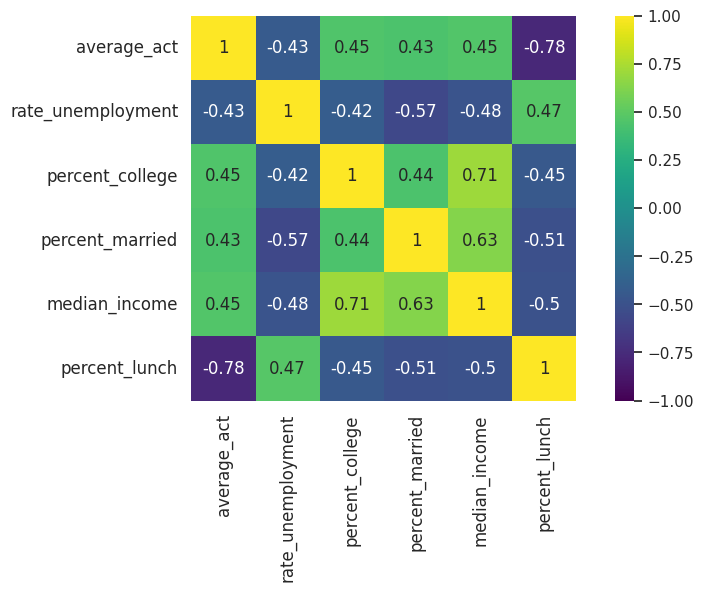

In [57]:
corr_matrix = df_train[['average_act','rate_unemployment','percent_college','percent_married','median_income','percent_lunch']].corr()

plt.figure(figsize=(10,5))

sns.heatmap(corr_matrix, vmax=1, vmin=-1, square=True, annot=True, cmap='viridis')

plt.tick_params(labelsize=12);

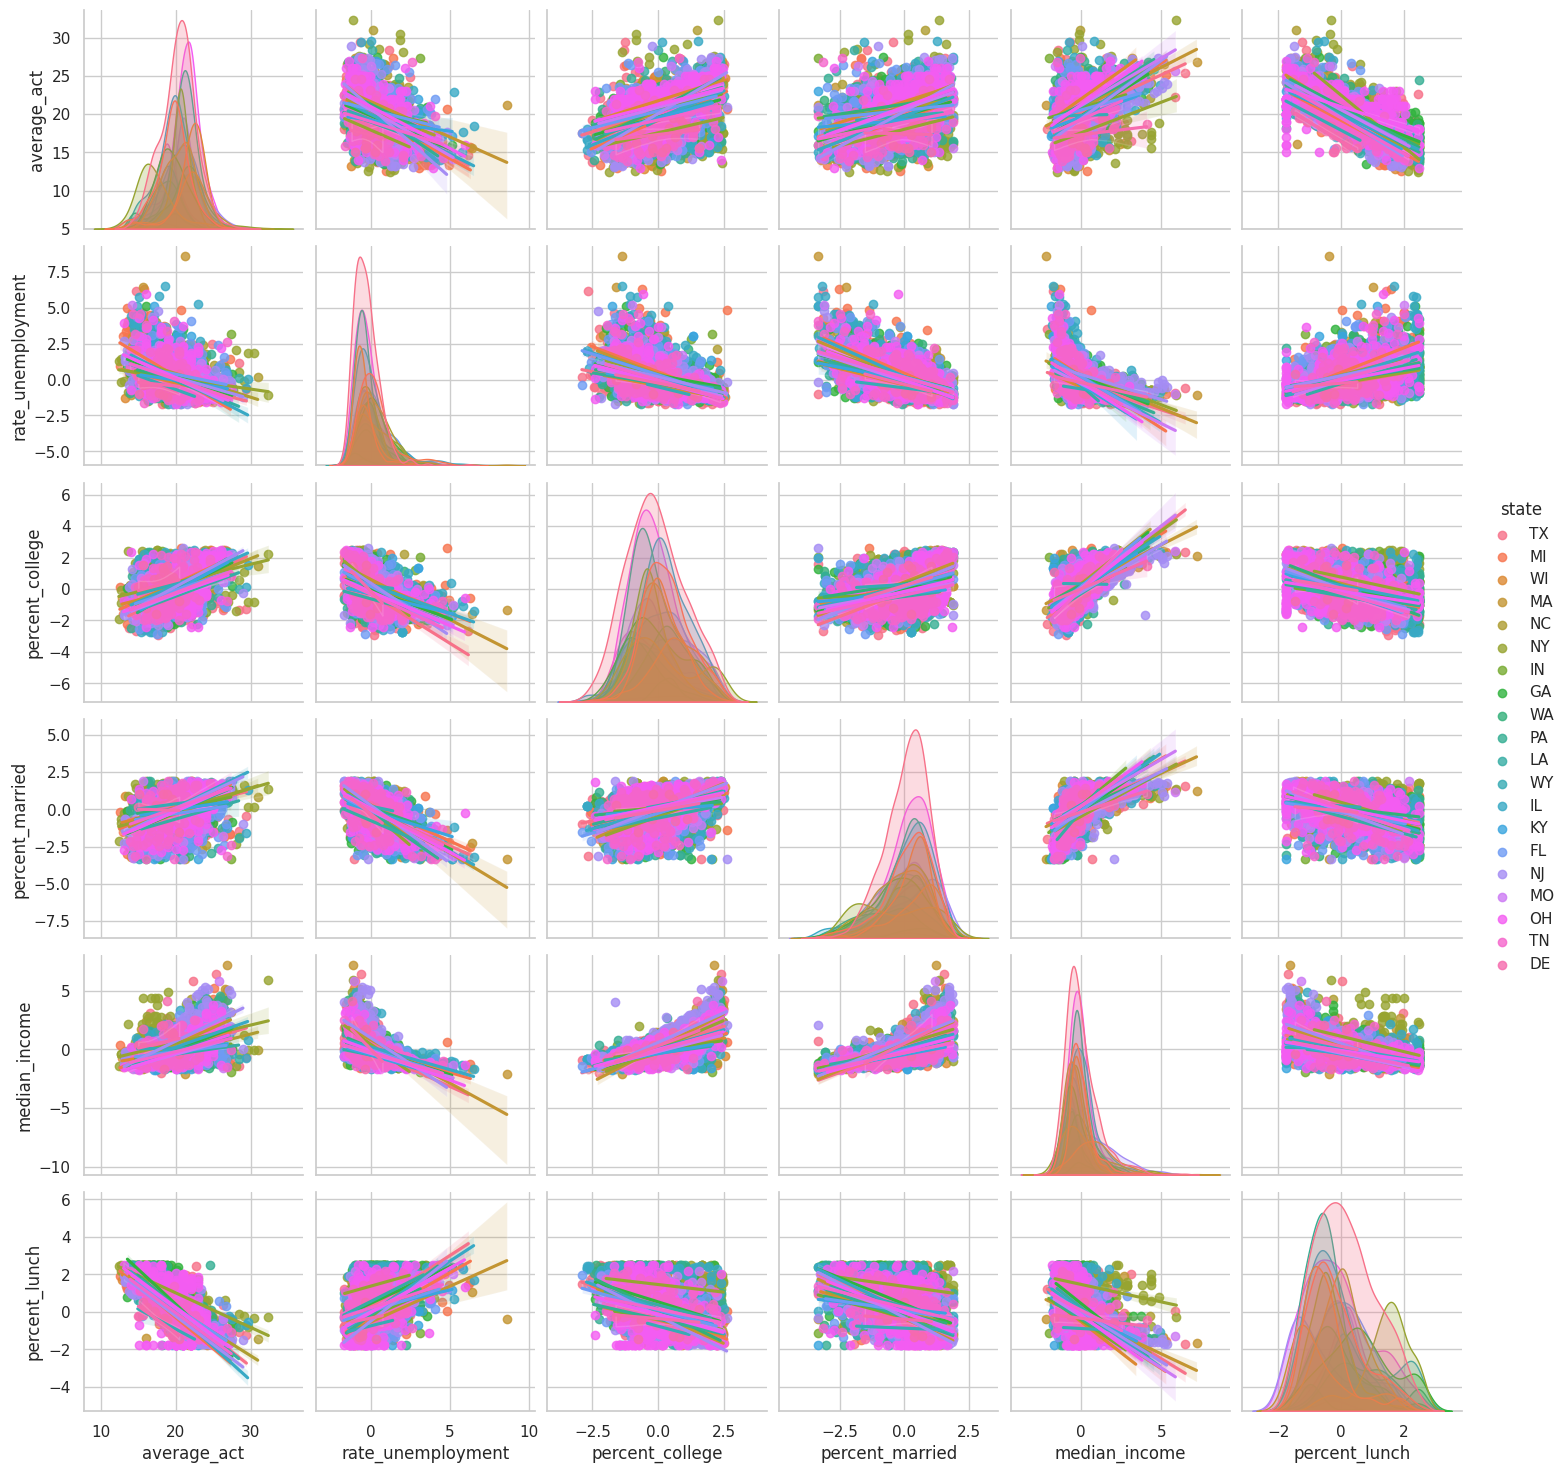

In [58]:
sns.pairplot(data=df_train,
             vars=['average_act','rate_unemployment','percent_college','percent_married','median_income','percent_lunch'],
             hue='state',
             kind='reg');

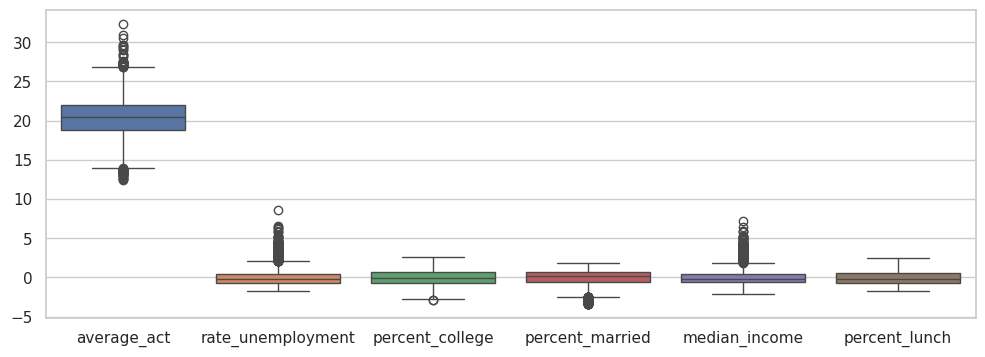

In [59]:
plt.figure(figsize=(12,4))
sns.boxplot(data=df_train[['average_act','rate_unemployment','percent_college','percent_married','median_income','percent_lunch']]);

# Modeling

The below function design_matrices generates and returns design matrices for training and testing datasets

In [60]:
def design_matrices(formula, df_train, df_test):

    _, X_design_train = dmatrices(formula,
                                  data=df_train,
                                  return_type='dataframe')

    _, X_design_test = dmatrices(formula,
                                 data=df_test,
                                 return_type='dataframe')

    return X_design_train, X_design_test

In [61]:
X_design_train, X_design_test = design_matrices('average_act ~(rate_unemployment + percent_college + percent_married + median_income + percent_lunch)', df_train, df_test)

In [62]:
df_train.isna().sum()

,0
rate_unemployment,0
percent_college,0
percent_married,0
median_income,0
percent_lunch,0
state,0
zip_code,0
average_act,0


In [63]:
X_design_train.head()

,Intercept,rate_unemployment,percent_college,percent_married,median_income,percent_lunch
6372,1.0,-0.551089,-2.435468,0.075820,-0.992249,1.645765
2991,1.0,-0.338844,0.734382,-0.111489,0.171997,-0.535976
7826,1.0,-0.266136,-1.173531,0.929105,-0.422611,-0.243009
7797,1.0,-0.500982,-0.714236,0.194961,-0.182737,-0.418151
2332,1.0,1.764387,-0.625856,-2.664541,-1.084493,0.510242


In below code, training the OLS model

In [64]:
model = sm.OLS(y_train, X_design_train).fit()

In [65]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     1901.
Date:                Wed, 25 Sep 2024   Prob (F-statistic):               0.00
Time:                        22:42:40   Log-Likelihood:                -10727.
No. Observations:                5781   AIC:                         2.147e+04
Df Residuals:                    5775   BIC:                         2.151e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            20.2892      0.02

In [66]:
y_hat = model.predict(X_design_train)

In above code, predictons are being made

Below code plots a scatter plot of the actual vs. predicted training set values

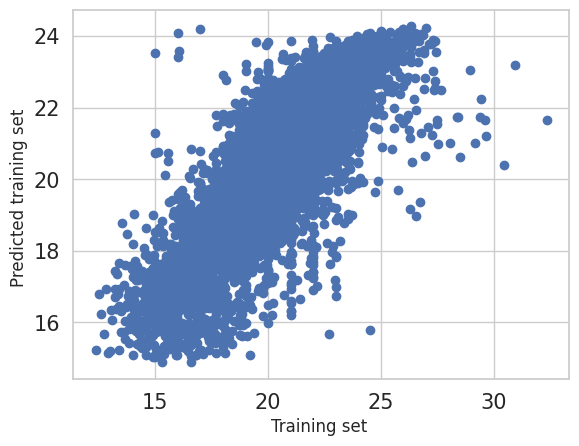

In [67]:
plt.plot(y_train, y_hat, 'o')

plt.xlabel('Training set ', fontsize = 12)
plt.ylabel('Predicted training set ', fontsize = 12)

plt.tick_params(labelsize = 15);

In [68]:
y_predict_lr = model.predict(X_design_test)

In above code, making predictions

Below code plots a scatter plot of the actual vs. predicted test set values

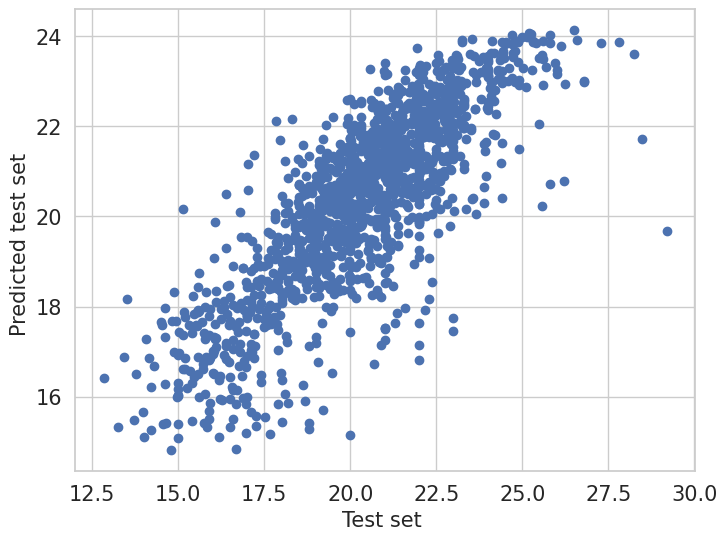

In [69]:
plt.figure(figsize = (8,6))

plt.plot(y_test, y_predict_lr, 'o');

plt.xlabel('Test set ', fontsize = 15)
plt.ylabel('Predicted test set ', fontsize = 15)

plt.tick_params(labelsize = 15)

In below codes, RMSE and MAE are calculated

In [70]:
mean_squared_error(y_test, y_predict_lr, squared = False).round(3)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


1.457

In [71]:
mean_absolute_error(y_test, y_predict_lr).round(3)

1.107

In [72]:
X_train

,rate_unemployment,percent_college,percent_married,median_income,percent_lunch,state,zip_code
6372,-0.551089,-2.435468,0.075820,-0.992249,1.645765,TX,77039
2991,-0.338844,0.734382,-0.111489,0.171997,-0.535976,MI,49261
7826,-0.266136,-1.173531,0.929105,-0.422611,-0.243009,WI,54460
7797,-0.500982,-0.714236,0.194961,-0.182737,-0.418151,WI,53573
2332,1.764387,-0.625856,-2.664541,-1.084493,0.510242,MA,2121
...,...,...,...,...,...,...,...
84,-0.269215,0.838885,1.300072,1.289730,-0.105196,FL,33073
4407,-1.315402,-0.691640,-0.158875,-0.536852,0.917885,NC,27105
6648,-1.066947,-0.611965,-0.178803,-0.642674,-0.843495,TX,76448
7673,-0.509207,0.346259,0.055489,0.818113,-1.224318,WI,53022


In below code, Random Forest Regressor model is implemented with hyperparameter tuning

In [73]:
rf_model = RandomForestRegressor()

params = {
    "max_depth": randint(2, 18),
    "n_estimators": randint(80, 150),
    "min_samples_leaf": randint(1, 8)
}

search = RandomizedSearchCV(rf_model,
                            param_distributions=params,
                            n_iter=50,
                            cv=5,
                            verbose=1,
                            n_jobs=1,
                            return_train_score=True,
                            scoring = 'neg_mean_squared_error')


search.fit(X_train.drop(columns=['state','zip_code']), y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=50, n_jobs=1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x798b7fd80220>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x798b7fd81de0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x798b7fd80ca0>},
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In below code best values of selected parameters are displayed

In [74]:
search.best_params_

{'max_depth': 9, 'min_samples_leaf': 6, 'n_estimators': 146}

The code initializes a `RandomForestRegressor` model with the best hyperparameters found by the `RandomizedSearchCV`.

In [75]:
model_rf = RandomForestRegressor(**search.best_params_)

In [76]:
X_train

,rate_unemployment,percent_college,percent_married,median_income,percent_lunch,state,zip_code
6372,-0.551089,-2.435468,0.075820,-0.992249,1.645765,TX,77039
2991,-0.338844,0.734382,-0.111489,0.171997,-0.535976,MI,49261
7826,-0.266136,-1.173531,0.929105,-0.422611,-0.243009,WI,54460
7797,-0.500982,-0.714236,0.194961,-0.182737,-0.418151,WI,53573
2332,1.764387,-0.625856,-2.664541,-1.084493,0.510242,MA,2121
...,...,...,...,...,...,...,...
84,-0.269215,0.838885,1.300072,1.289730,-0.105196,FL,33073
4407,-1.315402,-0.691640,-0.158875,-0.536852,0.917885,NC,27105
6648,-1.066947,-0.611965,-0.178803,-0.642674,-0.843495,TX,76448
7673,-0.509207,0.346259,0.055489,0.818113,-1.224318,WI,53022


The below code trains model_rf on X_train without the state and zip_code columns, using y_train as the target.

In [77]:
model_rf.fit(X_train.drop(columns=['state','zip_code']), y_train)

RandomForestRegressor(max_depth=9, min_samples_leaf=6, n_estimators=146)

In below code, predictions are made

In [78]:
y_predict_rf = model_rf.predict(X_test.drop(columns=['state','zip_code']))

The code creates a scatter plot of actual vs. predicted test set average ACT scores

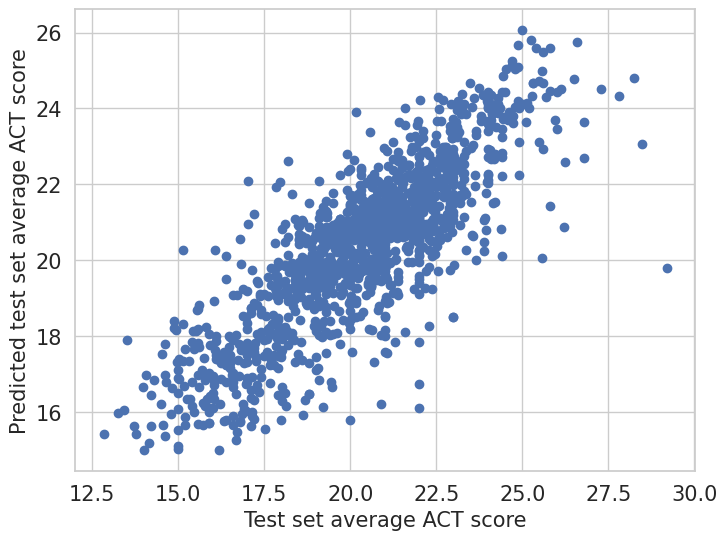

In [79]:
plt.figure(figsize = (8,6))

plt.plot(y_test, y_predict_rf, 'o');

plt.xlabel('Test set average ACT score', fontsize = 15)
plt.ylabel('Predicted test set average ACT score', fontsize = 15)

plt.tick_params(labelsize = 15)

Below code computes RMSE and MAE

In [80]:
# Calculate R-squared
r_squared = r2_score(y_test, y_predict_rf)

# Output the R-squared value
print(f"R-squared: {r_squared}")

R-squared: 0.6763905044048747


In [81]:
mean_squared_error(y_test, y_predict_rf, squared = False  ).round(3)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


1.406

In [82]:
mean_squared_error(y_test, y_predict_rf, squared = True  ).round(3)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


1.976

In [83]:
mean_absolute_error(y_test, y_predict_rf).round(3)

1.064

Below code plots a bar chart of feature importances

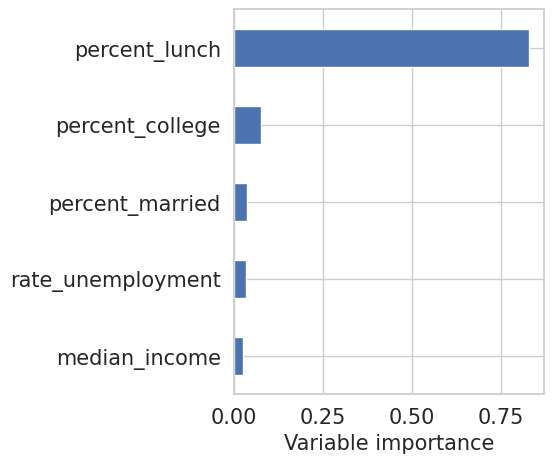

In [84]:
(pd.DataFrame(dict(cols=X_train.drop(columns=['state','zip_code']).columns, imp=model_rf.feature_importances_)).
 sort_values(by = 'imp').
 plot('cols', 'imp', 'barh', legend = False, figsize = (4,5)))

plt.ylabel('')
plt.xlabel('Variable importance', fontsize = 15)

plt.tick_params(labelsize = 15);

The analysis suggests that measures of a shcool's rate_unemployment,	percent_college,	percent_married	,median_income,	percent_lunch	are related to average_act

percent_lunch is very useful in predicting the average_act variable

RandomForestRegressor is better in predicting the average_act variable compared to OLS model